# ACN JPL EV load forecast


In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt

import tensorflow as tf
import forecast_tools as ft

#pd.set_option('precision', 2)
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
class RunTheJoules:
    def __init__(self,
                 site,                     
                 filename,
                 models_dir='./models/',
                 data_points_per_day = 96,
                 np_horizon = 7*96,
                 data_col = 1,
                 resample='15min'):
        self.site = site
        self.data_points_per_day = data_points_per_day
        self.np_horizon = np_horizon        
        self.models_dir = models_dir
        self.filename = filename
        self.data_col = data_col
        self.resample = resample,
        self.df = self.get_data()
        
    def get_data(self):
        df = pd.read_csv(  self.filename,   
                            comment='#',
                            parse_dates=True,
                            index_col=0,
                            usecols=[0,self.data_col] )

        df.columns = ['Load (kW)']

        #df = df.tz_localize('Etc/GMT+8',ambiguous='infer') # or 'US/Eastern' but no 'US/Pacific'
        df = df.resample('15min').mean()
        #df = df.tz_convert(None)
        df = df.fillna(method='ffill').fillna(method='bfill') 

        df = ft.emd_sift(df)
                                    
        #df['Day'] = df.index.dayofyear
        #df['Hour'] = df.index.hour
        #df['Weekday'] = df.index.dayofweek
        
        df['Persist'] = df['Load (kW)'].shift(self.data_points_per_day*7)
        
        df = df.fillna(method='bfill')
        
        df = df[:'2022-08']

        return df
        
    def go(self,features,units,dropout,n_in,epochs=100,patience=10,verbose=0,output=False,plots=False):
        layers = len(units)
        
        
        df = self.df[features]
        
        # header       
        
        units_str = ''
        for u in units:
            units_str += (str(u)+' ')
        
        print(f'\n\n////////// units={units_str} layers={layers} //////////\n')

        # meta
        y, m, d = datetime.now().year-2000, datetime.now().month, datetime.now().day
        path_checkpoint = self.models_dir+ f'{self.site} lstm {units_str} {y}{m}{d}.keras'

        ( n_features_x, n_features_y, 
            batchgen, dat_valid, 
            scaler) = ft.organize_dat_v2( df=df, 
                                        shift_steps=self.data_points_per_day,
                                        sequence_length=n_in)

        (x_test, y_test) = dat_valid 

        # np
        y_test_naive_mse = ft.naive_forecast_mse( y_test[0,:,0],
                                                    horizon=self.data_points_per_day)

        # model      
        print(path_checkpoint)                              
        model, hx = ft.train_lstm_v4(  n_features_x, n_features_y, 
                                        path_checkpoint, batchgen, 
                                        dat_valid, units, epochs,
                                        layers, patience, 
                                        verbose, dropout=dropout)
                                    
        # evaluate
        y_test_predict = model.predict(x_test)

        y_test_pred_kw = scaler.inverse_transform(y_test_predict[:,:,0]).flatten()
        y_test_kw      = scaler.inverse_transform(y_test[:,:,0]).flatten()

        test_rmse_np = ft.rmse(  y_test_kw[self.np_horizon:], 
                                y_test_kw[:-(self.np_horizon)] )

        results = {}
        results['test_rmse_pred']     = ft.rmse(y_test_kw, y_test_pred_kw)
        results['test_skill']         = 1 - results['test_rmse_pred'] / test_rmse_np  
        results['test_std_diff_pred'] = np.diff(y_test_pred_kw).std()
        results['epochs']             = len(hx.history['loss']) - patience

        if output:
            print('test set')
            print(f'rmse np   {test_rmse_np:.2f}')
            print(f'rmse pred {ft.rmse(y_test_kw, y_test_pred_kw):.2f}')
            print(f'skill     {1 - ft.rmse(y_test_kw, y_test_pred_kw)/test_rmse_np:.3f}')

        # plot
        if plots:
            ft.plot_training_history(hx)
            ft.plot_predictions_week(y_test_kw, y_test_pred_kw, week=0)

        return results, hx.history
    
jpl = RunTheJoules('acn-jpl',
                   models_dir='./models/acn-jpl/',
                   filename='C:/Users/Admin/OneDrive - Politecnico di Milano/Data/Load/Vehicle/ACN/train_JPL_4_mjw.csv')
results, history = jpl.go(features=['Load (kW)','Persist'] + [f'IMF{x}' for x in range(3,7)],
                          units=[24,24],dropout=[0,0],n_in=96,
                          epochs=100,patience=15,
                          plots=True,output=True,verbose=1)

C:\Users\Admin\AppData\Local\Temp\ipykernel_8984\1387090124.py:31: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')
C:\Users\Admin\AppData\Local\Temp\ipykernel_8984\1387090124.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill')




////////// units=24 24  layers=2 //////////

./models/acn-jpl/acn-jpl lstm 24 24  23925.keras
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 24)          2976      
                                                                 
 dropout (Dropout)           (None, None, 24)          0         
                                                                 
 lstm_1 (LSTM)               (None, None, 24)          4704      
                                                                 
 dropout_1 (Dropout)         (None, None, 24)          0         
                                                                 
 dense (Dense)               (None, None, 1)           25        
                                                                 
Total params: 7,705
Trainable params: 7,705
Non-trainable params: 0
________________________

KeyboardInterrupt: 

# data analysis

## get dat

In [5]:
jpl = RunTheJoules('acn-jpl')
jpl.df

,Load (kW),IMF1,IMF2,IMF3,IMF4,IMF5,IMF6,IMF7,IMF8,IMF9,IMF10,IMF11
timestamp_utc,,,,,,,,,,,,
2020-11-09 08:00:00,0.000000,261.946809,20.895385,-72.996661,-118.628040,-56.527871,-38.071360,6.544533,0.849504,-18.317946,0.000661,14.304987
2020-11-09 08:15:00,0.000000,261.108762,15.115844,-72.101472,-114.757224,-55.236266,-37.519343,6.558810,0.831352,-18.307918,0.004065,14.303390
2020-11-09 08:30:00,0.000000,259.755575,9.261441,-70.844936,-110.687960,-53.919990,-36.961750,6.572971,0.813250,-18.297863,0.007471,14.301792
2020-11-09 08:45:00,0.000000,257.887517,3.353421,-69.236165,-106.431591,-52.580010,-36.398671,6.587015,0.795197,-18.287783,0.010878,14.300193
2020-11-09 09:00:00,0.000000,255.504856,-2.586969,-67.284274,-101.999459,-51.217294,-35.830196,6.600941,0.777192,-18.277678,0.014287,14.298594
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31 22:45:00,92.271308,1.362975,-2.642294,-4.001168,50.253979,0.071551,20.355112,-0.785931,-3.445555,-55.481759,687.398174,-600.813774
2022-08-31 23:00:00,88.086917,-0.921411,-4.516062,-2.913862,49.263015,-0.030075,20.399787,-0.846350,-3.446736,-55.425563,687.585945,-601.061771
2022-08-31 23:15:00,89.087048,0.848580,-5.117652,-1.691347,47.997044,-0.132402,20.443008,-0.906880,-3.447876,-55.369315,687.773678,-601.309790


In [15]:
jpl.df.describe()

,Load (kW),IMF1,IMF2,IMF3,IMF4,IMF5,IMF6,IMF7,IMF8,IMF9,IMF10,IMF11
count,63424.000000,63424.000000,63424.000000,63424.000000,63424.000000,63424.000000,63424.000000,63424.000000,63424.000000,63424.000000,63424.000000,63424.000000
mean,29.666892,-0.272826,3.490336,0.435390,-0.561229,-0.397076,0.468611,-0.290405,-0.451580,-6.440786,-75.631642,109.318099
std,40.017735,12.329169,23.665147,35.613001,31.871271,15.779040,17.446208,6.029046,5.493401,20.742309,319.367609,314.775185
min,0.000000,-165.872858,-83.249379,-140.753151,-118.628040,-76.696714,-63.364066,-17.423206,-14.677630,-91.494150,-758.688815,-601.805895
25%,0.000000,-1.643065,-5.010220,-18.953399,-20.613015,-11.114987,-12.352086,-4.276846,-3.550132,-3.999310,-260.631560,-112.754733
50%,4.512226,0.076812,0.579715,-0.174402,-0.522551,-0.303951,0.442798,-0.049373,0.019585,-0.674219,54.878318,-17.242065
75%,68.406979,1.859812,9.783526,17.356161,20.751482,10.158291,13.141100,3.320066,3.049107,2.337530,136.896395,300.236722
max,151.292562,261.946809,220.909727,125.728483,108.904061,63.248790,70.899903,21.782179,13.166080,16.272668,688.149032,781.580365


<Axes: xlabel='timestamp_utc'>

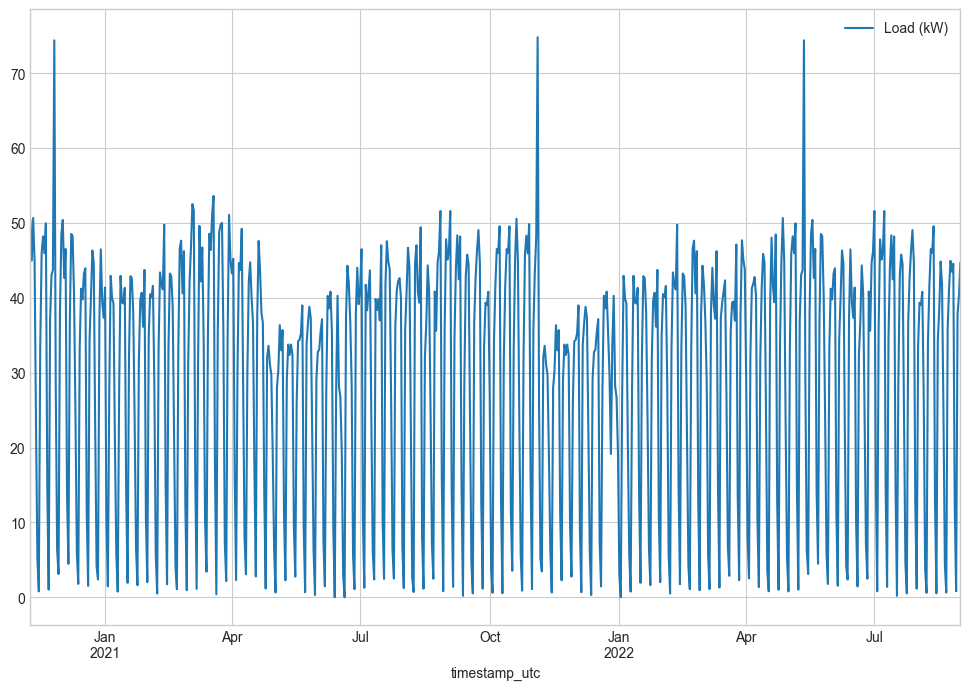

In [16]:
jpl.df[['Load (kW)']].resample('D').mean().plot(figsize=(12,8))

## np

In [6]:
d_all = jpl.df['Load (kW)'].values.flatten()
ppd = jpl.data_points_per_day
d = d_all

# all np 1 day
d_true_1d = d[ppd:]
d_np_1d = d[:-ppd]

print('all rmse np 1 day %.2f' % np.sqrt(np.mean(np.square( d_true_1d - 
                                                         d_np_1d ))))

d_true_7d = d[ppd*7:]
d_np_7d = d[:-ppd*7]

print('all rmse np 7 day %.2f' % np.sqrt(np.mean(np.square( d_true_7d - 
                                                          d_np_7d ))))

i = int(.9*len(d_all))
d = d_all[i:]

# test np 1 day
d_true96 = d[ppd:]
d_np1d96 = d[:-ppd]

print('test rmse np 96 %.2f' % np.sqrt(np.mean(np.square( d_true96 - 
                                                          d_np1d96 ))))

# test np 7 day
d_true672 = d[7*ppd:]
d_np1d672 = d[:-7*ppd]

print('test rmse np 672 %.2f' % np.sqrt(np.mean(np.square( d_true672 - 
                                                            d_np1d672 ))))

all rmse np 1 day 32.22
all rmse np 7 day 16.70
test rmse np 96 34.26
test rmse np 672 16.23


## weekly

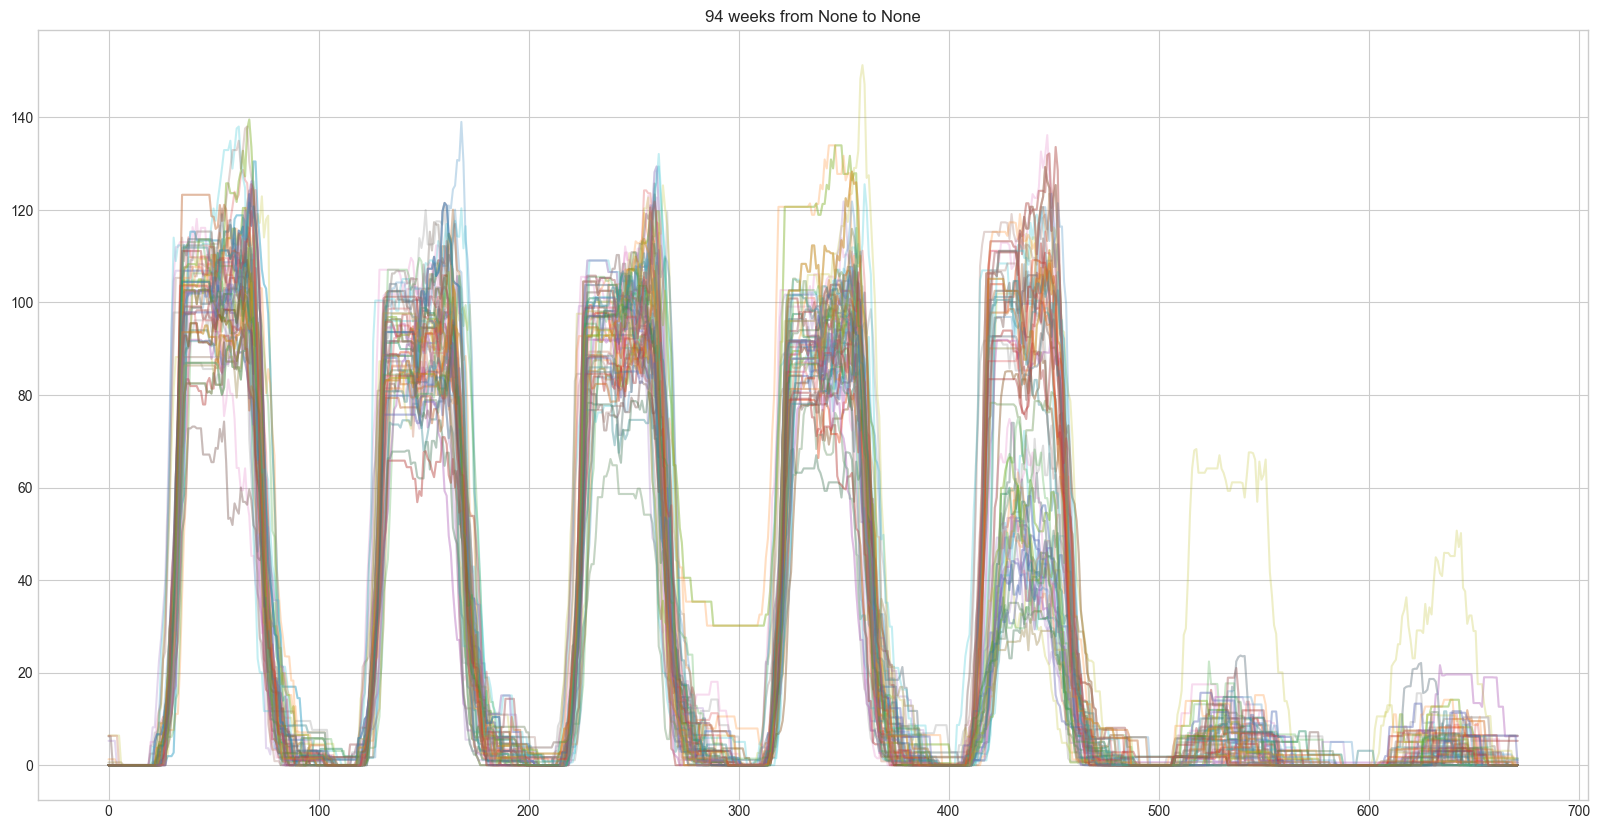

In [24]:
ft.plot_weekly_overlaid(jpl.df,ppd=96)

## stationarity

note that if you change the ylim to 150 and 250 the signal will appear to vary a lot, but that would be true of almost any signal. here the ylim is set to 0, and about double the "mean of the moving standard deviation".

<Axes: title={'center': 'Monthly Stdev'}, xlabel='Datetime (UTC-8)'>

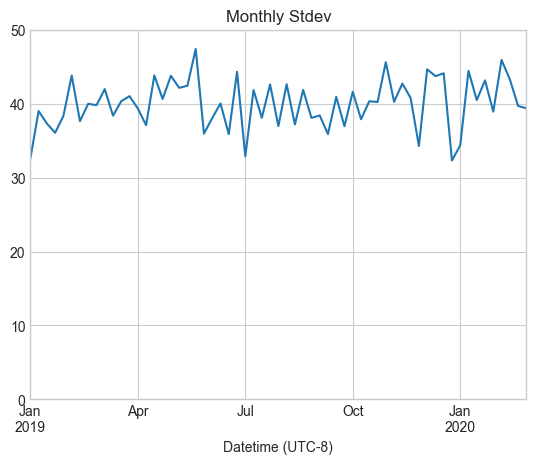

In [22]:
df['Load (kW)'].resample('W').std().plot(ylim=[0,50],title='Monthly Stdev')

<Axes: title={'center': 'Monthly Mean'}, xlabel='Datetime (UTC-8)'>

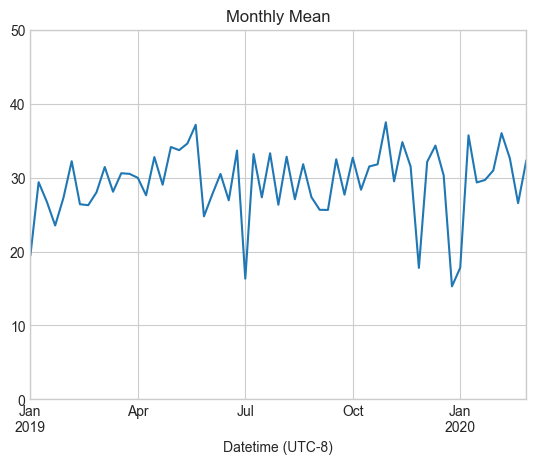

In [24]:
df['Load (kW)'].resample('W').mean().plot(ylim=[0,50],title='Monthly Mean')

## normality

In [25]:
ft.shapiro_wilk_test(df['Load (kW)'].values.flatten())

Ratio of failed tests to total tests: 1.000000


<Axes: >

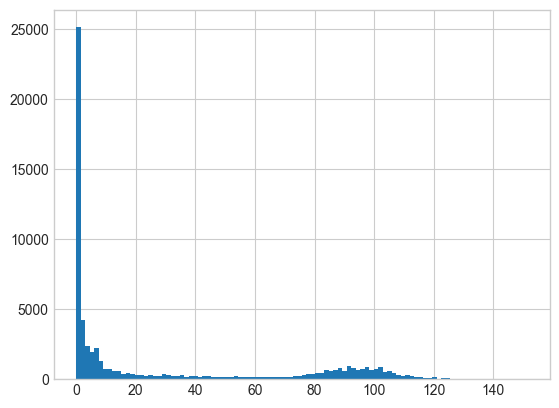

In [26]:
df['Load (kW)'].hist(bins=100)

Hist of all samples at hour 'h' and day of week 'd'

In [ ]:
for d in range(7):
    for h in range(24):
        idx = np.multiply(  df['Load (kW)'].index.hour    == h,
                            df['Load (kW)'].index.weekday == d)
        
        data = df['Load (kW)'][idx].values.flatten()
        p = ft.shapiro_wilk_test_v2(data, N=len(data), output=False)

        plt.hist(data,bins=50)
        plt.title(f'Weekday {d}, hour {h}, {len(data)} samples, p-val={p:.3f}')
        plt.show()

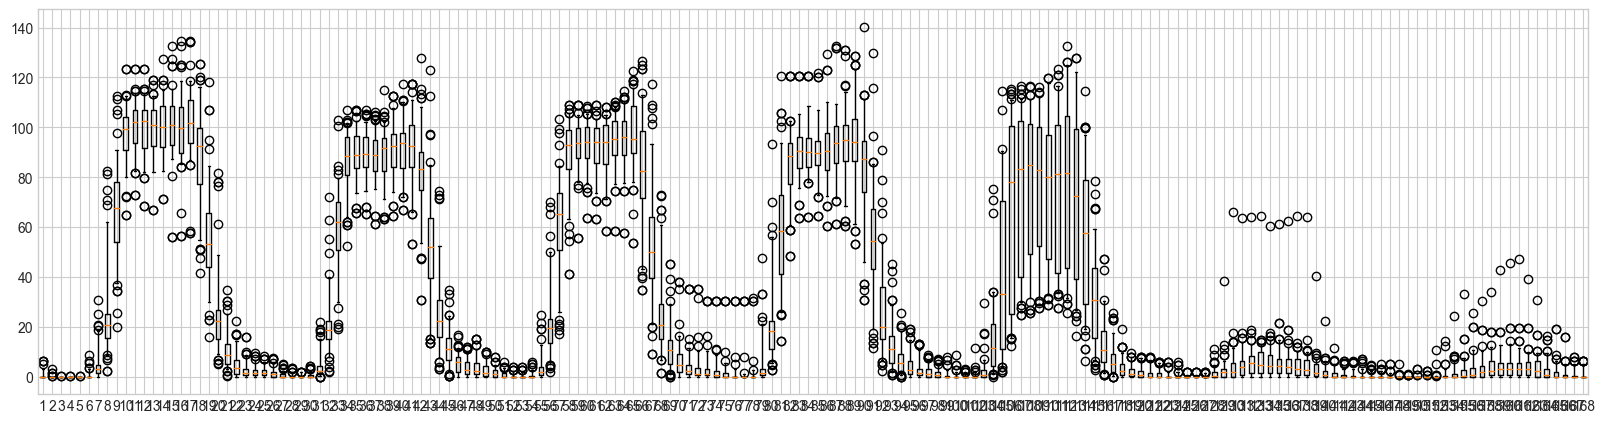

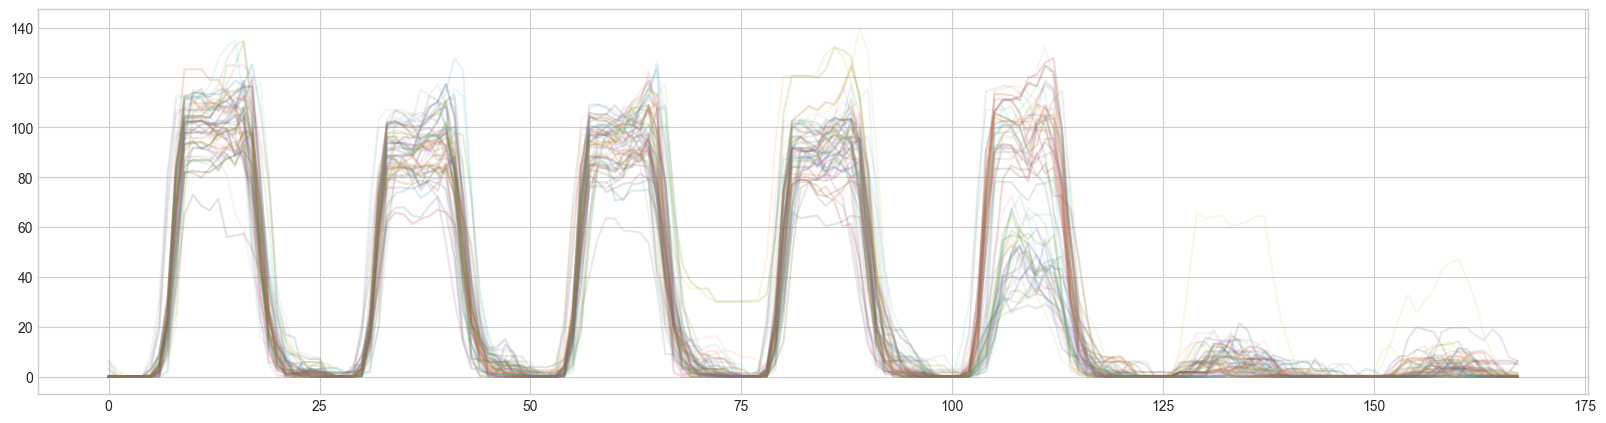

In [63]:
df_h = df.resample('H').mean()


d = df_h['Load (kW)'].values.flatten()
n = int(len(d)/168)
d = d[:(n*168)].reshape(n,168).T

plt.figure(figsize=(20,5))
plt.boxplot(d.T,whis=[5,95])
plt.show()

plt.figure(figsize=(20,5))
plt.plot(d,alpha=0.1)
plt.show()


## feature eng

Correlation of IMFx with load

In [64]:
x = df[['Load (kW)']].values.flatten()

for i in range(1,11):
  y = df[[f'IMF{i}']].values.flatten()
  print(f'IMF{i} {np.corrcoef(x,y)[0,1]:.3f}')

IMF1 0.016
IMF2 -0.045
IMF3 0.499
IMF4 0.400
IMF5 0.261
IMF6 0.335
IMF7 0.041
IMF8 0.006
IMF9 -0.004
IMF10 -0.009


# grid search

best so far: 24x96 d0.2 in288

In [12]:
rx = {}
hx = {}
for units1 in [24,48,96,128,256,512]:
  for units2 in [24,48,96,128,256,512]:
    for dropout in [0., 0.2]:
      for n_in in [96,2*96,3*96]:
        model_name = f'lstm u1{units1}u2{units2}d{dropout}n{n_in}'        
        results, history = jpl.go(features=['Load (kW)','Persist'] + [f'IMF{x}' for x in range(3,7)],
                          units=[units1,units2],dropout=2*[dropout],n_in=n_in,
                          epochs=100,patience=15,
                          plots=False,output=True,verbose=0)
rx = pd.DataFrame(rx).transpose()
rx.to_csv(jpl.model_dir+'results.csv')
rx



////////// units=24 24  layers=2 //////////

./models/acn-jpl/acn-jpl lstm 24 24  23911.keras
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_33 (LSTM)              (None, None, 24)          2976      
                                                                 
 dropout_33 (Dropout)        (None, None, 24)          0         
                                                                 
 lstm_34 (LSTM)              (None, None, 24)          4704      
                                                                 
 dropout_34 (Dropout)        (None, None, 24)          0         
                                                                 
 dense_17 (Dense)            (None, None, 1)           25        
                                                                 
Total params: 7705 (30.10 KB)
Trainable params: 7705 (30.10 KB)
Non-trainable params: 0 (